# Day 8 - Lab 1: Vision-Enabled UI/UX Agents

**Objective:** Use multi-modal vision models to generate a frontend UI from a design image, and then use a second agent to perform an automated design review.

**Estimated Time:** 90 minutes

**Introduction:**
Welcome to Day 8! Today, we'll explore one of the most exciting advancements in AI: vision. We will use a vision-capable model to act as a frontend developer, translating a design image directly into code. Then, we will create a second "UI/UX Critic" agent to automate the design review process, demonstrating a complete, AI-assisted frontend workflow.

For definitions of key terms used in this lab, please refer to the [GLOSSARY.md](../../GLOSSARY.md).

## Step 1: Setup

For this lab, we need to ensure we are using a vision-capable model. We will configure our `utils.py` helper to use a model like OpenAI's `gpt-4o` or Google's `gemini-2.5-pro`.

**Model Selection:**
This lab requires a vision-capable model. Excellent choices include `gpt-4o`, `gemini-2.5-pro`, or `deepseek-ai/DeepSeek-VL2`.

**Helper Functions Used:**
- `setup_llm_client()`: To configure the API client.
- `get_vision_completion()`: A specialized function to send an image and a text prompt to a vision model.
- `get_completion()`: To send text-only prompts for the refactoring step.
- `save_artifact()`: To save the generated code and the design review.

In [12]:
import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_vision_completion, get_image_generation_completion, get_completion, save_artifact, clean_llm_output, recommended_models_table
from IPython.display import Image, display, Code

# image_client, image_model_name, image_api_provider = setup_llm_client(model_name="stabilityai/stable-diffusion-3.5-large")
image_client, image_model_name, image_api_provider = setup_llm_client(model_name="gemini-2.5-flash-image-preview")
print(f"✅ Using {image_model_name} for image generation")

# Ensure you select a vision-capable model
vision_client, vision_model_name, vision_api_provider = setup_llm_client(model_name="gemini-2.5-pro")
print(f"✅ Using {vision_model_name} for vision tasks")


if not image_model_name or not vision_model_name:
    print("Could not set up a valid LLM client. Please check your .env file and utils.py configuration.")

2025-11-03 10:12:01,001 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-image-preview latency_ms=None artifacts_path=None
2025-11-03 10:12:01,022 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-pro latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash-image-preview for image generation
✅ Using gemini-2.5-pro for vision tasks


In [2]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| MiniMaxAI/MiniMax-M2 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 8,192 |
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-haiku-4-5-20251001 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 32,000 |
| claude-sonnet-4-5-20250929 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |
| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |
| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |
| gemini-2.0-flash-exp | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4.1-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4.1-nano | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini-transcribe | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |
| gpt-4o-transcribe | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-nano-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.1-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.1-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| MiniMaxAI/MiniMax-M2 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 8,192 |\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-haiku-4-5-20251001 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 32,000 |\n| claude-sonnet-4-5-20250929 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |\n| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |\n| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |\n| gemini-2.0-flash-exp 

## Step 2: The Design Screenshot

This is the design we want our AI agent to build. It's a simple login form component. We will provide the URL to this image directly to the model.

Using gemini-2.5-flash-image-preview for image generation...
✅ Generated image saved to: /Users/brianfisher/trainingRepos/AG-AISOFTDEV/artifacts/screens/image_1762183926.png



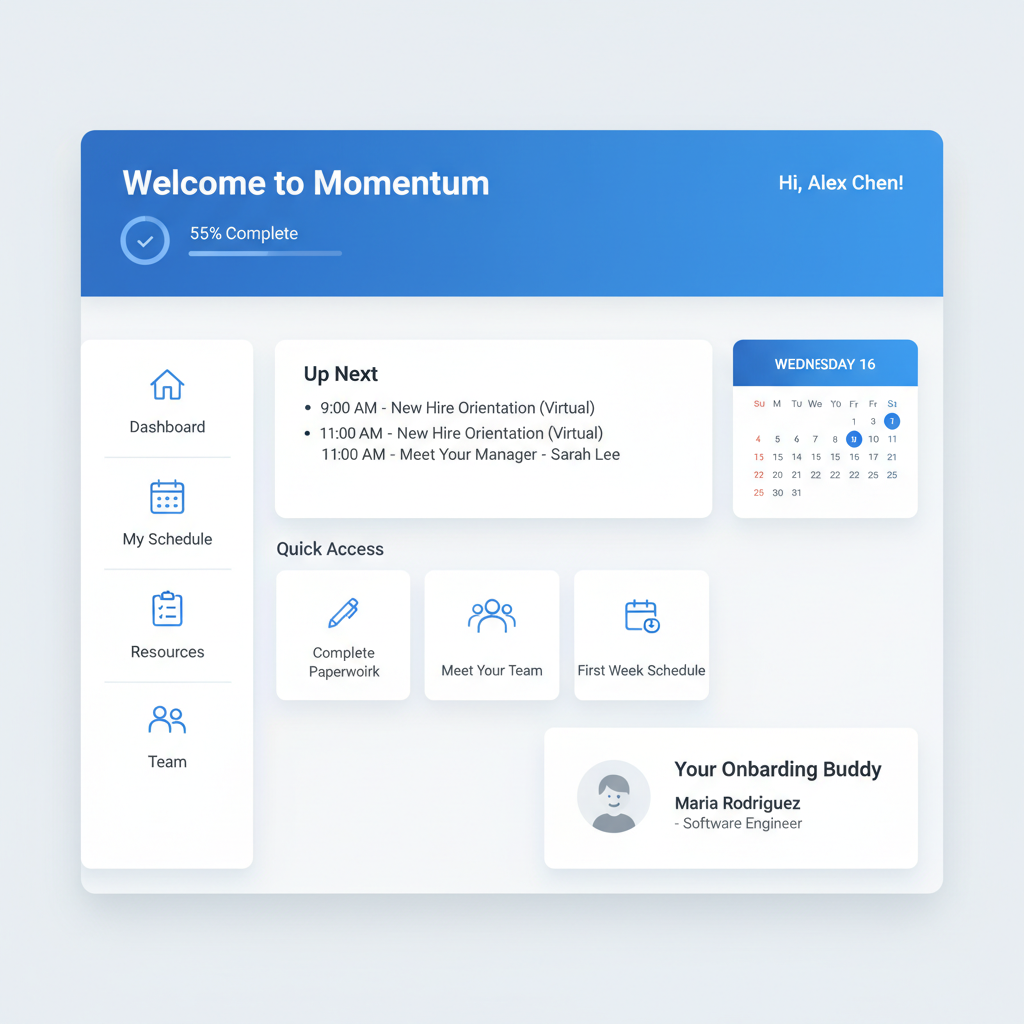

In [14]:
# screen_generation_prompt = "an onboarding tool homepage screen with modern UI design, clean layout, welcome message, and navigation elements"
screen_generation_prompt = """A modern employee onboarding platform dashboard homepage with a clean, professional design. 
The screen should include:
- A welcoming header with 'Welcome to Momentum' branding and the new hire's name
- A progress indicator showing onboarding completion percentage
- A sidebar navigation with icons for Dashboard, My Schedule, Tasks, Resources, and Team
- Main content area featuring:
  - An 'Up Next' section showing today's onboarding tasks and meetings
  - A weekly calendar preview widget
  - Quick access cards for 'Complete Paperwork', 'Meet Your Team', and 'First Week Schedule'
  - A 'Your Onboarding Buddy' card with a profile photo placeholder
- Use a corporate blue and white color scheme with professional typography
- Include subtle card shadows and rounded corners for modern UI elements
- Desktop web application layout optimized for 1440px width"""

print(f"Using {image_model_name} for image generation...")
file_path, image_url = get_image_generation_completion(screen_generation_prompt, image_client, image_model_name, image_api_provider)

# Display the generated image if successful
if file_path and image_url:
    print(f"✅ Generated image saved to: {file_path}")
    display(Image(url=image_url))
elif image_url:
    print(f"❌ Image generation failed: {image_url}")
else:
    print("❌ Image generation returned no result")

In [4]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| MiniMaxAI/MiniMax-M2 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 8,192 |
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-haiku-4-5-20251001 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 32,000 |
| claude-sonnet-4-5-20250929 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |
| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |
| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |
| gemini-2.0-flash-exp | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4.1-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4.1-nano | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,000 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini-transcribe | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |
| gpt-4o-transcribe | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-nano-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.1-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.1-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| MiniMaxAI/MiniMax-M2 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 8,192 |\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-haiku-4-5-20251001 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 32,000 |\n| claude-sonnet-4-5-20250929 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 64,000 |\n| dall-e-3 | openai | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-1.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 8,192 |\n| gemini-1.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 2,000,000 | 8,192 |\n| gemini-2.0-flash-exp 

In [5]:
login_form_url = "https://i.imgur.com/s42SYz6.png"
display(Image(url=login_form_url))

## Step 3: The Challenges

### Challenge 1 (Foundational): Generating a Monolithic UI Component

**Task:** Use the vision model to generate a single, self-contained React component that replicates the design from the image.

> **Tip for Vision Prompts:** Be specific about the output format. Telling the model you want 'React' and 'Tailwind CSS' is crucial. The more specific your technical constraints, the better the generated code will be.

**Instructions:**
1.  Create a prompt that asks the vision model to act as an expert frontend developer.
2.  The prompt should instruct the model to analyze the image at the provided URL.
3.  Ask it to generate a single React component using Tailwind CSS for styling.
4.  The output should be a single block of JSX code.

**Expected Quality:** A single file's worth of React code that, when rendered, visually approximates the login form in the screenshot.

In [17]:
# Explain the specified image using the vision-capable LLM
image_path = "/Users/brianfisher/trainingRepos/AG-AISOFTDEV/artifacts/screens/image_1762183926.png"

# explain_image_prompt = f"""
# You are an expert frontend developer and UI/UX designer. Analyze the provided image and produce a clear, actionable explanation for a developer who will implement the UI.

# Please respond in markdown and include the following sections:

# 1) Summary: One-sentence summary of what this screen is (purpose).
# 2) Visual Breakdown: Enumerate the visible UI elements (e.g., header, logo, form fields, buttons, icons, images) and approximate positions (top/left/center, grouping).
# 3) Style Details: Describe colors, font styles (weight/size/line-height if evident), spacing, borders/radii, shadows, and alignment cues.
# 4) Interaction & Behavior: Identify interactive elements and the likely behaviors (hover/focus states, validation, keyboard affordances).
# 5) Accessibility Notes: Potential accessibility issues and recommended fixes (labels, contrast, focus order).
# 6) Implementation Plan (React + Tailwind): Suggest component names and a short mapping of each component to Tailwind utilities or structure (e.g., <LoginForm> -> container: flex, gap-4, ...). Keep this as a concise checklist.

# Keep the output developer-focused and actionable.
# """

explain_image_prompt = f"""
You are an expert frontend developer and UI/UX designer. Analyze the provided Momentum Onboarding Platform dashboard image 
and produce a comprehensive, actionable explanation for a developer implementing this UI with React and Tailwind CSS.

Respond in markdown format with the following sections. Be thorough and specific in each section:

## 1. Summary
One clear sentence describing the screen's purpose in the onboarding workflow.

## 2. Layout Structure
Describe the overall page layout:
- Header structure and content
- Sidebar/navigation placement and items
- Main content area organization
- How sections are arranged (grid, flex, etc.)

## 3. Visual Component Inventory
List every visible UI element with its location and purpose:
- Navigation items (links, menus, buttons)
- Content cards and their contents
- Form elements (if any)
- Progress indicators or status displays
- Icons and images
- Interactive widgets (calendars, lists, etc.)
- Text elements (headings, labels, descriptions)

Be specific about what each component contains and displays.

## 4. Typography & Color System
Document the visual styling:
- Font families, sizes, and weights for different text types
- Color palette (backgrounds, text, accents, borders)
- Specific hex codes or color names where identifiable

## 5. Spacing & Visual Effects
Describe:
- Padding and margins between elements
- Card and container spacing
- Border radius values
- Shadow effects and elevation
- Alignment patterns

## 6. Interactive Elements
Identify all clickable/interactive elements and their expected behaviors:
- Buttons and their actions
- Navigation links and routing
- Hover states
- Focus indicators
- Form interactions (if applicable)

## 7. Accessibility Considerations
Note any accessibility issues or requirements:
- Color contrast problems
- Missing labels or ARIA attributes
- Focus order concerns
- Text sizing issues

## 8. React Component Structure
Suggest a logical component breakdown:
- Name each major component
- Describe its responsibility
- Note which components are reusable
- Identify parent-child relationships

Do NOT use a tree diagram. Instead, write in prose describing each component and how they relate.

## 9. Tailwind CSS Implementation Notes
For each major section, specify the key Tailwind utility classes needed:
- Layout utilities (flex, grid, container)
- Spacing classes
- Typography classes
- Color utilities
- Responsive modifiers
- State variants

Write these as descriptions, not code examples.

## 10. Data Requirements
What dynamic data does this screen need?
- User information
- Task lists
- Schedule data
- Progress metrics
- Team member information

Provide thorough, detailed responses for each section. Write in complete sentences and paragraphs, not just bullet points.
"""



print("--- Requesting image explanation from vision model ---")
if vision_model_name:
    explanation = get_vision_completion(explain_image_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_explanation = clean_llm_output(explanation, language="markdown")
    display(Code(cleaned_explanation, language="markdown"))
    # Save the explanation for later reference
    save_artifact(cleaned_explanation, "docs/image_explanation.md", base_dir=project_root, overwrite=True)
else:
    print("Skipping image explanation because no vision model is configured.")

--- Requesting image explanation from vision model ---


Of course. Here is a comprehensive, actionable analysis for implementing the Momentum Onboarding Platform dashboard using React and Tailwind CSS.

***

## 1. Summary
This screen serves as the central dashboard for a new employee, providing a clear overview of their immediate schedule, key tasks, and overall onboarding progress.

## 2. Layout Structure
The overall page layout is clean and structured, using a spacious, card-based design on a light gray background.

-   **Header structure and content:** A full-width, prominent header banner sits at the top of the main content area. It has a blue gradient background and contains the main page title ("Welcome to Momentum"), a progress indicator, and a personalized user greeting ("Hi, Alex Chen!"). This is structured using Flexbox to space the title/progress on the left and the greeting on the right.
-   **Sidebar/navigation placement and items:** A vertical navigation sidebar is positioned in the left column. It is visually contained within its own card with a white background and soft shadow. It consists of four vertically-stacked navigation items, each with an icon and a label. The active item ("Dashboard") is visually distinct.
-   **Main content area organization:** The area to the right of the sidebar contains the primary dashboard widgets. This area is organized into a vertical flow of sections.
-   **How sections are arranged:** The overall page below the header is a two-column grid. The left column is narrow (for the sidebar) and the right column is wide (for the content). The right content column is further organized:
    1.  A top row using a two-column grid or flexbox, with the "Up Next" card occupying more space on the left and the smaller "Calendar" widget on the right.
    2.  A "Quick Access" section below that, which uses a three-column grid for its interactive cards.
    3.  A final, single-column row at the bottom for the "Your Onboarding Buddy" card.

## 3. Visual Component Inventory
Here is a list of every visible UI element and its purpose.

-   **Header Banner:**
    -   **Title:** Large, bold heading "Welcome to Momentum".
    -   **Progress Indicator:** A circular icon with a checkmark, the text "55% Complete", and a horizontal progress bar, indicating the user's completion of onboarding tasks.
    -   **User Greeting:** A simple text element "Hi, Alex Chen!" on the far right.

-   **Navigation Sidebar:**
    -   **Dashboard Link:** The active navigation item, indicated by blue, filled-in icon and bold blue text. Contains a "home" icon.
    -   **My Schedule Link:** An inactive link with an outlined calendar icon.
    -   **Resources Link:** An inactive link with an outlined document/list icon.
    -   **Team Link:** An inactive link with an outlined icon representing multiple people.

-   **Content Cards & Widgets:**
    -   **"Up Next" Card:** A white card with the heading "Up Next". It contains an unordered list of upcoming events for the day, each item showing the time and a description (e.g., "9:00 AM - New Hire Orientation (Virtual)").
    -   **Calendar Widget:** A compact card displaying a mini month calendar. It has a blue header showing the current day and date ("WEDNESDAY 16"). The body is a grid of dates, with the current date highlighted with a blue circular background. Days from other months are shown in a different color (red/orange).
    -   **"Quick Access" Section:** A heading "Quick Access" followed by three smaller, interactive cards.
        -   **Complete Paperwork Card:** An icon of a pencil/document and the label "Complete Paperwork".
        -   **Meet Your Team Card:** An icon of three people and the label "Meet Your Team".
        -   **First Week Schedule Card:** An icon of a calendar with a plus sign and the label "First Week Schedule".
    -   **"Your Onboarding Buddy" Card:** A dedicated card to introduce a team member. It contains a heading "Your Onboarding Buddy", a circular user avatar, the buddy's name ("Maria Rodriguez"), 

In [18]:
# TODO: Write a prompt to generate a single React component from the image.
generate_ui_prompt = f"""
You are an expert frontend developer specializing in React and Tailwind CSS. Your task is to analyze the provided UI design image and generate a complete, production-ready React component that faithfully replicates the design.

Requirements:
1. Create a single, self-contained React component as a functional component
2. Use Tailwind CSS utility classes exclusively for all styling (no custom CSS)
3. Replicate the exact visual design from the image, including:
   - Layout structure and spacing
   - Typography (font sizes, weights, colors)
   - Color scheme (backgrounds, text colors, borders)
   - Icons and visual elements
   - Button styles and form elements
   - Shadows, borders, and rounded corners
4. Use appropriate semantic HTML elements
5. Include placeholder text and content as shown in the image
6. Make the component responsive if the design suggests it
7. Add appropriate props for any dynamic content (user names, progress data, etc.)

Output:
- Return ONLY the complete JSX code for the component
- Include all necessary imports (React, icons if needed)
- Use descriptive component and variable names
- Add brief comments for complex sections
- Ensure the code is properly formatted and indented

Analyze the image carefully and generate the React component now.
"""

print("--- Generating Monolithic UI Component ---")
if vision_model_name:
    generated_monolithic_code = get_vision_completion(generate_ui_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_code = clean_llm_output(generated_monolithic_code, language='jsx')
    display(Code(cleaned_code, language='jsx'))
else:
    print("Skipping UI generation because no valid model is configured.")
    cleaned_code = ""

--- Generating Monolithic UI Component ---


import React from 'react';

// SVG Icon Components (for self-containment)
const HomeIcon = (props) => (
  <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}>
    <path strokeLinecap="round" strokeLinejoin="round" d="M3 12l2-2m0 0l7-7 7 7M5 10v10a1 1 0 001 1h3m10-11l2 2m-2-2v10a1 1 0 01-1 1h-3m-6 0a1 1 0 001-1v-4a1 1 0 011-1h2a1 1 0 011 1v4a1 1 0 001 1m-6 0h6" />
  </svg>
);

const CalendarIcon = (props) => (
  <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}>
    <path strokeLinecap="round" strokeLinejoin="round" d="M8 7V3m8 4V3m-9 8h10M5 21h14a2 2 0 002-2V7a2 2 0 00-2-2H5a2 2 0 00-2 2v12a2 2 0 002 2z" />
  </svg>
);

const DocumentIcon = (props) => (
  <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}>
    <path strokeLinecap="round" strokeLinejoin="round" d="M9 12h6m-6 4h6m2 5H7a2 2 0 01-2-2V5a2 2 0 012-2h5.586a1 1 0 01.707.293l5.414 5.414a1 1 0 01.293.707V19a2 2 0 01-2 2z" />
  </svg>
);

const TeamIcon = (props) => (
  <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}>
    <path strokeLinecap="round" strokeLinejoin="round" d="M17 20h5v-2a3 3 0 00-5.356-1.857M17 20H7m10 0v-2c0-.653-.125-1.283-.356-1.857M7 20H2v-2a3 3 0 015.356-1.857M7 20v-2c0-.653.125-1.283.356-1.857m0 0a5.002 5.002 0 019.288 0M15 7a3 3 0 11-6 0 3 3 0 016 0zm6 3a2 2 0 11-4 0 2 2 0 014 0zM7 10a2 2 0 11-4 0 2 2 0 014 0z" />
  </svg>
);

const CheckCircleIcon = (props) => (
    <svg xmlns="http://www.w3.org/2000/svg" className="h-8 w-8" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}>
        <path strokeLinecap="round" strokeLinejoin="round" d="M9 12l2 2 4-4m6 2a9 9 0 11-18 0 9 9 0 0118 0z" />
    </svg>
);

const PencilIcon = (props) => (
    <svg xmlns="http://www.w3.org/2000/svg" className="h-8 w-8 text-blue-500" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}>
        <path strokeLinecap="round" strokeLinejoin="round" d="M11 5H6a2 2 0 00-2 2v11a2 2 0 002 2h11a2 2 0 002-2v-5m-1.414-9.414a2 2 0 112.828 2.828L11.828 15H9v-2.828l8.586-8.586z" />
    </svg>
);

const MeetTeamIcon = (props) => (
    <svg xmlns="http://www.w3.org/2000/svg" className="h-8 w-8 text-blue-500" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}>
        <path strokeLinecap="round" strokeLinejoin="round" d="M12 4.354a4 4 0 110 5.292M15 21H3v-1a6 6 0 0112 0v1zm0 0h6v-1a6 6 0 00-9-5.197M15 21a6 6 0 00-9-5.197M15 11a3 3 0 11-6 0 3 3 0 016 0z" />
    </svg>
);

const FirstWeekIcon = (props) => (
    <svg xmlns="http://www.w3.org/2000/svg" className="h-8 w-8 text-blue-500" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}>
        <path strokeLinecap="round" strokeLinejoin="round" d="M8 7V3m8 4V3m-9 8h10M5 21h14a2 2 0 002-2V7a2 2 0 00-2-2H5a2 2 0 00-2 2v12a2 2 0 002 2zM12 18a3 3 0 100-6 3 3 0 000 6z" />
    </svg>
);


// Main Dashboard Component
const OnboardingDashboard = ({
  userName = "Alex Chen",
  completionPercentage = 55,
  onboardingBuddy = { name: "Maria Rodriguez", role: "Software Engineer" },
}) => {
  const navItems = [
    { name: "Dashboard", icon: <HomeIcon />, active: true },
    { name: "My Schedule", icon: <CalendarIcon /> },
    { name: "Resources", icon: <DocumentIcon /> },
    { name: "Team", icon: <TeamIcon /> },
  ];

  const upcomingEvents = [
    { time: "9:00 AM", description: "New Hire Orientation (Virtual)" },
    { time: "11:00 AM", description: "New Hire Orientation (Virtual)" },
    { time: "11:00 AM", description: "Meet Your Manager - Sarah Lee" },
  ];

  const quickAccessItems = [
    { name: "Complete Paperwork", icon: <PencilIcon /> },
    { name: "Meet Your Team", icon:

### Challenge 2 (Intermediate): Refactoring into Reusable Components

**Task:** A single, large component is not good practice. Now, prompt the LLM to refactor the monolithic code it just generated into smaller, reusable sub-components.

**Instructions:**
1.  Create a new prompt.
2.  Provide the monolithic JSX code from the previous step as context.
3.  Instruct the LLM to act as a senior frontend developer who champions clean code.
4.  Ask it to refactor the code by creating smaller, reusable components (e.g., `<StyledButton>`, `<InputWithIcon>`).
5.  The final output should be the complete code with the new, smaller components defined and used within the main `Login` component.

**Expected Quality:** A well-structured React file that demonstrates the component-based architecture, which is a fundamental best practice in modern frontend development.

In [19]:
# TODO: Write a prompt to refactor the monolithic code into smaller components.
refactor_ui_prompt = f"""
You are a senior frontend developer and React architecture expert who champions clean code, maintainability, and component reusability.

Your task is to refactor the following monolithic React component into a well-structured, component-based architecture.

ORIGINAL CODE TO REFACTOR:
```jsx
{cleaned_code}
```

Refactoring Requirements:
1. Break down the monolithic component into smaller, reusable sub-components
2. Create dedicated components for common UI patterns such as:
   - Buttons (e.g., `Button`, `IconButton`)
   - Form inputs (e.g., `Input`, `InputWithIcon`)
   - Cards (e.g., `Card`, `StatCard`, `TaskCard`)
   - Navigation items (e.g., `NavItem`, `SidebarNav`)
   - Progress indicators (e.g., `ProgressBar`, `ProgressCircle`)
   - Any other repeated UI patterns you identify
3. Follow React best practices:
   - Use prop destructuring
   - Add PropTypes or TypeScript interfaces (choose PropTypes for simplicity)
   - Use composition over inheritance
   - Keep components focused on a single responsibility
   - Extract reusable logic where appropriate
4. Maintain the exact same visual output and functionality
5. Keep all Tailwind CSS styling
6. Organize components logically (helper components before main component)
7. Add brief JSDoc comments for each component explaining its purpose and props

Output Format:
- Return the complete refactored code
- Define all sub-components first, then the main component that uses them
- Include all necessary imports
- Ensure proper formatting and indentation
- Add comments to explain the component structure

Begin the refactoring now, focusing on creating clean, reusable, and maintainable code.
"""

print("--- Refactoring UI into Components ---")
if cleaned_code:
    refactored_code = get_completion(refactor_ui_prompt, vision_client, vision_model_name, vision_api_provider)
    cleaned_refactored_code = clean_llm_output(refactored_code, language='jsx')
    display(Code(cleaned_refactored_code, language='jsx'))
else:
    print("Skipping refactoring because monolithic code was not generated.")
    cleaned_refactored_code = ""

--- Refactoring UI into Components ---


import React from 'react';
import PropTypes from 'prop-types';

// ============================================================================
// 1. ICON COMPONENTS
// In a real-world project, these would likely live in `components/icons/`
// and be exported from a single index file for easier imports.
// ============================================================================

const HomeIcon = (props) => ( <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}><path strokeLinecap="round" strokeLinejoin="round" d="M3 12l2-2m0 0l7-7 7 7M5 10v10a1 1 0 001 1h3m10-11l2 2m-2-2v10a1 1 0 01-1 1h-3m-6 0a1 1 0 001-1v-4a1 1 0 011-1h2a1 1 0 011 1v4a1 1 0 001 1m-6 0h6" /></svg> );
const CalendarIcon = (props) => ( <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}><path strokeLinecap="round" strokeLinejoin="round" d="M8 7V3m8 4V3m-9 8h10M5 21h14a2 2 0 002-2V7a2 2 0 00-2-2H5a2 2 0 00-2 2v12a2 2 0 002 2z" /></svg> );
const DocumentIcon = (props) => ( <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}><path strokeLinecap="round" strokeLinejoin="round" d="M9 12h6m-6 4h6m2 5H7a2 2 0 01-2-2V5a2 2 0 012-2h5.586a1 1 0 01.707.293l5.414 5.414a1 1 0 01.293.707V19a2 2 0 01-2 2z" /></svg> );
const TeamIcon = (props) => ( <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}><path strokeLinecap="round" strokeLinejoin="round" d="M17 20h5v-2a3 3 0 00-5.356-1.857M17 20H7m10 0v-2c0-.653-.125-1.283-.356-1.857M7 20H2v-2a3 3 0 015.356-1.857M7 20v-2c0-.653.125-1.283.356-1.857m0 0a5.002 5.002 0 019.288 0M15 7a3 3 0 11-6 0 3 3 0 016 0zm6 3a2 2 0 11-4 0 2 2 0 014 0zM7 10a2 2 0 11-4 0 2 2 0 014 0z" /></svg> );
const CheckCircleIcon = (props) => ( <svg xmlns="http://www.w3.org/2000/svg" className="h-8 w-8" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}><path strokeLinecap="round" strokeLinejoin="round" d="M9 12l2 2 4-4m6 2a9 9 0 11-18 0 9 9 0 0118 0z" /></svg> );
const PencilIcon = (props) => ( <svg xmlns="http://www.w3.org/2000/svg" className="h-8 w-8 text-blue-500" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}><path strokeLinecap="round" strokeLinejoin="round" d="M11 5H6a2 2 0 00-2 2v11a2 2 0 002 2h11a2 2 0 002-2v-5m-1.414-9.414a2 2 0 112.828 2.828L11.828 15H9v-2.828l8.586-8.586z" /></svg> );
const MeetTeamIcon = (props) => ( <svg xmlns="http://www.w3.org/2000/svg" className="h-8 w-8 text-blue-500" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}><path strokeLinecap="round" strokeLinejoin="round" d="M12 4.354a4 4 0 110 5.292M15 21H3v-1a6 6 0 0112 0v1zm0 0h6v-1a6 6 0 00-9-5.197M15 21a6 6 0 00-9-5.197M15 11a3 3 0 11-6 0 3 3 0 016 0z" /></svg> );
const FirstWeekIcon = (props) => ( <svg xmlns="http://www.w3.org/2000/svg" className="h-8 w-8 text-blue-500" fill="none" viewBox="0 0 24 24" stroke="currentColor" strokeWidth={2} {...props}><path strokeLinecap="round" strokeLinejoin="round" d="M8 7V3m8 4V3m-9 8h10M5 21h14a2 2 0 002-2V7a2 2 0 00-2-2H5a2 2 0 00-2 2v12a2 2 0 002 2zM12 18a3 3 0 100-6 3 3 0 000 6z" /></svg> );

// ============================================================================
// 2. GENERIC, REUSABLE UI COMPONENTS
// These are the building blocks of our UI (e.g., Card, ProgressBar).
// ============================================================================

/**
 * A simple progress bar component.
 * @param {object} props - The component props.
 * @param {number} props.percentage - The completion percentage (0-100).
 */
const ProgressBar = ({ percentage }) => (
  <div className="w-48 bg-white/30 rounded-full h-1.5 mt-1">
    <div className="bg-white h-1.5 rounded-full" style={{ width: `${percent

### Challenge 3 (Advanced): The AI UI/UX Critic Agent

**Task:** Create a new "UI/UX Critic" agent. This agent will be given both the original design image and the generated code, and its job is to perform an automated design review.

**Instructions:**
1.  Create a final, complex prompt for a new agent.
2.  The prompt should instruct the agent to act as a meticulous UI/UX designer.
3.  Provide the agent with two pieces of context: the URL of the original design image and the final, refactored React code.
4.  The agent's task is to compare the code's likely rendered output to the design image and list any visual inconsistencies in spacing, font size, color, or layout.

**Expected Quality:** A critical design review in markdown format. This demonstrates a powerful AI-on-AI workflow, where one AI generates work and another AI validates it, automating a time-consuming QA step.

In [20]:
# TODO: Write a prompt for the UI/UX Critic agent.
critic_agent_prompt = f"""
You are a meticulous UI/UX designer and design quality assurance specialist with extensive experience in frontend development and design systems.

Your task is to perform a comprehensive automated design review by comparing the provided design image with the React code implementation below.

REACT CODE IMPLEMENTATION:
```jsx
{cleaned_refactored_code}
```

Design Review Requirements:

Carefully analyze the provided design image and compare it against the React code implementation. Identify any visual inconsistencies, deviations, or potential issues in the following areas:

## 1. Layout & Structure
- Compare the overall page layout and structure
- Check component positioning and alignment
- Verify spacing between sections and elements
- Identify any missing or extra UI elements

## 2. Typography
- Font families, sizes, and weights
- Text colors and contrast
- Line heights and letter spacing
- Heading hierarchy

## 3. Color Scheme
- Background colors
- Text colors
- Button and interactive element colors
- Border colors
- Verify color consistency with the design

## 4. Spacing & Sizing
- Padding within elements
- Margins between elements
- Component dimensions (width, height)
- Gap spacing in flex/grid layouts

## 5. Visual Effects
- Border radius values
- Shadow effects
- Hover and focus states (if evident in code)
- Opacity and transparency

## 6. Icons & Graphics
- Icon presence and positioning
- Icon sizes and colors
- Image placeholders
- Any missing visual elements

## 7. Interactive Elements
- Button styles and states
- Form input styling
- Navigation elements
- Interactive widget accuracy

## 8. Responsive Behavior
- Check if responsive classes match design intent
- Identify any missing responsive considerations

## 9. Component Architecture Quality
- Assess the quality of component breakdown
- Identify opportunities for better reusability
- Check for proper prop usage

## Output Format:

Provide your design review in the following markdown format:

# UI/UX Design Review

## Summary
[Brief overview of overall code quality and design fidelity - 2-3 sentences]

## Strengths
[List 3-5 things the implementation does well]

## Visual Inconsistencies
[For each inconsistency, use this format:]
### Issue: [Brief title]
- **Location**: [Which component/section]
- **Design**: [What the design shows]
- **Implementation**: [What the code produces]
- **Severity**: [Critical/High/Medium/Low]
- **Recommendation**: [How to fix it]

## Accessibility Concerns
[Any accessibility issues identified]

## Code Quality Observations
[Comments on component structure, reusability, and maintainability]

## Overall Assessment
[Final verdict with a rating out of 10 for design fidelity]

Be thorough, specific, and constructive in your feedback. Focus on actionable insights that would help a developer improve the implementation.
"""

print("--- Invoking UI/UX Critic Agent ---")
if cleaned_refactored_code:
    design_review = get_vision_completion(critic_agent_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    display(Code(design_review, language='markdown'))
    save_artifact(design_review, "artifacts/design_review.md")
else:
    print("Skipping critic agent because refactored code is not available.")

--- Invoking UI/UX Critic Agent ---


Excellent. As a meticulous UI/UX designer and QA specialist, I will now perform a comprehensive automated design review.

Here is my detailed analysis comparing the design image to the provided React code.

# UI/UX Design Review

## Summary
The React implementation provides a strong functional foundation for the onboarding dashboard. The component architecture is commendable, demonstrating good separation of concerns and reusability. However, there are several notable visual and structural deviations from the design, particularly in the main page layout, header details, and sidebar styling, which prevent it from being a pixel-perfect match.

## Strengths
*   **Excellent Componentization**: The code is well-organized into logical, reusable components (e.g., `Card`, `ProgressBar`, `NavItem`), which is fantastic for maintainability and scalability.
*   **Effective Use of Tailwind CSS**: The utility-first approach is well-utilized, and responsive classes (`sm:`, `lg:`, `xl:`) are used to create a flexible layout.
*   **Prop-Driven Components**: Components are made reusable and dynamic through well-defined props, complete with `PropTypes` for validation.
*   **Attention to Detail (in places)**: Specific details like the red coloring for Sundays in the calendar and the gradient in the header are implemented correctly, showing a good eye for parts of the design.
*   **Clear Code Structure**: The file is organized into logical sections (Icons, Generic UI, App-specific), making it easy to read and understand.

## Visual Inconsistencies

### Issue: Incorrect Main Layout and Sidebar Placement
- **Location**: `OnboardingDashboard` and `SidebarNav` components.
- **Design**: The sidebar navigation stands on its own, aligned to the left within the main white container. The content area (with "Up Next", "Calendar", etc.) is a separate column to the right of the sidebar.
- **Implementation**: The `SidebarNav` component is placed *inside* the main grid (`<div className="grid grid-cols-1 lg:grid-cols-4 gap-8">`), which is itself inside the main white card (`<main>`). This contains the sidebar within the same visual boundary as the rest of the content, which is structurally incorrect.
- **Severity**: Critical
- **Recommendation**: The main page layout needs to be restructured. The `main` tag should not wrap the sidebar. Instead, the `main` content area and the `SidebarNav` should be sibling elements within a grid container that sits on the light gray page background.

```jsx
// Before (Incorrect Structure)
<main className="mt-[-2rem] bg-white rounded-xl shadow-lg p-6 lg:p-8">
  <div className="grid grid-cols-1 lg:grid-cols-4 gap-8">
    <SidebarNav items={navItems} /> {/* Sidebar is inside the card */}
    <div className="lg:col-span-3">...</div>
  </div>
</main>

// After (Corrected Structure)
<div className="grid grid-cols-1 lg:grid-cols-4 gap-8">
  {/* Sidebar is a direct child of the grid, not inside a separate card */}
  <SidebarNav items={navItems} /> 
  {/* The main content can now be wrapped in its own container if needed, or have cards inside */}
  <main className="lg:col-span-3 mt-[-2rem]"> 
    <div className="bg-white rounded-xl shadow-lg p-6 lg:p-8">
        {/* ... rest of the content grid ... */}
    </div>
  </main>
```
*(Note: The above recommendation is a conceptual fix; the exact implementation might need more adjustment to achieve the overlapping header effect correctly across the whole content area.)*

### Issue: Header Progress Indicator Icon and Background
- **Location**: `CompletionProgress` component.
- **Design**: The checkmark icon is a simple white check inside a solid, slightly darker blue circular background.
- **Implementation**: The code uses a `CheckCircleIcon` (a checkmark inside a circle outline) placed on a semi-transparent white background (`bg-white/20`). This results in a different icon shape and background effect.
- **Severity**: High
- **Recommendation**:
    1.  Replace the `CheckCircleIcon` with a simple

## Step 4: Save and Preview the Generated UI

Now let's save the final generated code and create an HTML wrapper so we can view it in a browser. This will also prepare it for eventual integration with the backend app.

In [23]:
import os
from pathlib import Path
import re

print("--- Saving Generated Code and Creating HTML Preview ---")

if cleaned_refactored_code:
    # Save the React component code
    component_path = os.path.join(project_root, "artifacts", "generated_ui", "OnboardingDashboard.jsx")
    os.makedirs(os.path.dirname(component_path), exist_ok=True)
    
    with open(component_path, 'w') as f:
        f.write(cleaned_refactored_code)
    
    print(f"✅ React component saved to: {component_path}")
    
    # Clean up the code for browser compatibility
    # Remove import statements and export default
    browser_compatible_code = cleaned_refactored_code
    browser_compatible_code = re.sub(r"import\s+React\s+from\s+['\"]react['\"];?\s*\n?", "", browser_compatible_code)
    browser_compatible_code = re.sub(r"import\s+PropTypes\s+from\s+['\"]prop-types['\"];?\s*\n?", "", browser_compatible_code)
    browser_compatible_code = re.sub(r"export\s+default\s+\w+;?\s*\n?", "", browser_compatible_code)
    
    # Create an HTML wrapper for preview
    html_content = f"""<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Momentum Onboarding Dashboard - Preview</title>
    
    <!-- Tailwind CSS CDN -->
    <script src="https://cdn.tailwindcss.com"></script>
    
    <!-- React and ReactDOM from CDN -->
    <script crossorigin src="https://unpkg.com/react@18/umd/react.production.min.js"></script>
    <script crossorigin src="https://unpkg.com/react-dom@18/umd/react-dom.production.min.js"></script>
    
    <!-- PropTypes from CDN -->
    <script crossorigin src="https://unpkg.com/prop-types@15/prop-types.min.js"></script>
    
    <!-- Babel Standalone for JSX transformation -->
    <script src="https://unpkg.com/@babel/standalone/babel.min.js"></script>
    
    <style>
        body {{
            margin: 0;
            padding: 0;
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', 'Roboto', 'Oxygen',
                'Ubuntu', 'Cantarell', 'Fira Sans', 'Droid Sans', 'Helvetica Neue',
                sans-serif;
            -webkit-font-smoothing: antialiased;
            -moz-osx-font-smoothing: grayscale;
        }}
        
        #root {{
            min-height: 100vh;
        }}
    </style>
</head>
<body>
    <div id="root"></div>
    
    <script type="text/babel">
        // Use global React and PropTypes from CDN
        const {{ useState, useEffect }} = React;
        
        {browser_compatible_code}
        
        // Render the component
        const root = ReactDOM.createRoot(document.getElementById('root'));
        root.render(<OnboardingDashboard />);
    </script>
</body>
</html>"""
    
    # Save the HTML file
    html_path = os.path.join(project_root, "artifacts", "generated_ui", "preview.html")
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"✅ HTML preview saved to: {html_path}")
    print(f"\n🌐 To view the generated UI, open the following file in your browser:")
    print(f"   file://{html_path}")
    
    # Also save to artifacts for the save_artifact tracking
    save_artifact(cleaned_refactored_code, "generated_ui/OnboardingDashboard.jsx", base_dir=project_root, overwrite=True)
    
    print(f"\n📝 Note: This UI is ready to be integrated with the FastAPI backend in /app")
    print(f"   Next steps for integration:")
    print(f"   1. Convert to a proper React project with build tools (Vite/Create React App)")
    print(f"   2. Connect to the FastAPI endpoints in /app/main.py")
    print(f"   3. Replace mock data with real API calls")
    
else:
    print("⚠️  No code to save. Please run the previous cells first.")

--- Saving Generated Code and Creating HTML Preview ---
✅ React component saved to: /Users/brianfisher/trainingRepos/AG-AISOFTDEV/artifacts/generated_ui/OnboardingDashboard.jsx
✅ HTML preview saved to: /Users/brianfisher/trainingRepos/AG-AISOFTDEV/artifacts/generated_ui/preview.html

🌐 To view the generated UI, open the following file in your browser:
   file:///Users/brianfisher/trainingRepos/AG-AISOFTDEV/artifacts/generated_ui/preview.html

📝 Note: This UI is ready to be integrated with the FastAPI backend in /app
   Next steps for integration:
   1. Convert to a proper React project with build tools (Vite/Create React App)
   2. Connect to the FastAPI endpoints in /app/main.py
   3. Replace mock data with real API calls


## Lab Conclusion

Fantastic! You have completed a full, end-to-end frontend development workflow using multiple AI agents. You used a vision-powered agent to generate code from a design, a refactoring agent to improve the code's structure, and a critic agent to perform an automated design review. This powerful combination of skills can dramatically accelerate the process of turning visual ideas into functional user interfaces.

> **Key Takeaway:** The workflow of **Generate -> Refactor -> Critique** is a powerful AI-assisted development pattern. Using specialized agents for each step allows you to rapidly create a first draft, improve its quality, and then automatically check it for correctness, significantly speeding up the iteration cycle.